In [1]:
#
#Network Science - Air Traffic Data Preparation
#

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import seaborn as sns
import numpy as np
import csv
import pandas as pd
%matplotlib inline
import networkx as nx
from statistics import mean
from matplotlib.colors import Normalize, LinearSegmentedColormap, PowerNorm
from wordcloud import WordCloud


In [2]:
# please note that I am using my husbands old computer for school purposes. His name is Justin.
routes_headers = ['Airline', 'Airline_ID', 'Source_Airport', 'Source_Airport_ID', 'Dest_Airport', 'Dest_Airport_ID', 'Codeshare', 'Stops', 'Equipment']
routes_df = pd.read_csv(r"C:\Users\Justin\Dropbox\IU\INFO I606 NETWORK SCIENCE\Final Project\ProjectDataSet\ProjectDataSet\InputData_RawData\routes.dat", header=None, names = routes_headers)
routes_df.head()

,Airline,Airline_ID,Source_Airport,Source_Airport_ID,Dest_Airport,Dest_Airport_ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [3]:
routes_df['Source_Airport ID'] = pd.to_numeric(routes_df['Source_Airport_ID'].astype(str), 'coerce')
routes_df['Dest Airport_ID'] = pd.to_numeric(routes_df['Dest_Airport_ID'].astype(str), 'coerce')
routes_df = routes_df.dropna(subset=["Source_Airport_ID", "Dest_Airport_ID"])

In [4]:
routes_df =  pd.DataFrame(routes_df.groupby(['Source_Airport', 'Dest_Airport']).size().reset_index(name='flight_counts'))

In [5]:
# create counts variable to use as the graph egde attribute
flight_counts = routes_df['Source_Airport'].append(routes_df.loc[routes_df['Source_Airport'] != routes_df['Dest_Airport'], 'Dest_Airport']).value_counts()

flight_counts = pd.DataFrame({'IATA': flight_counts.index, 'total_flight': flight_counts})


In [7]:
# Create directed graph
G = nx.from_pandas_edgelist(routes_df, source = 'Source_Airport', target = 'Dest_Airport', edge_attr = 'flight_counts',create_using = nx.DiGraph())

In [8]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 3425
Number of edges: 37595
Average in degree:  10.9766
Average out degree:  10.9766


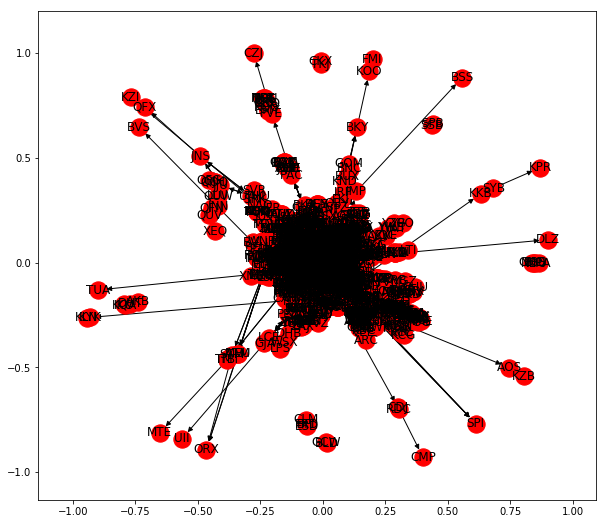

In [9]:
#plot the graph
plt.figure(figsize = (10,9))
nx.draw_networkx(G)

In [10]:
density = nx.density(G)
print("Network density:", round(density, 6))

Network density: 0.003206


In [11]:
degree_centrality = nx.degree_centrality(G)
# average degree centrality of the graph
count = 0
_sum = 0
for key in degree_centrality:
    count += 1
    _sum += degree_centrality[key]

print('Average Degree Centrality of the graph: ', round(_sum/count, 6))

Average Degree Centrality of the graph:  0.006412


In [12]:
# Get the eigenvector centralities for all the nodes
ev_centralities = nx.eigenvector_centrality(G)
# average eigenvector centrality of the graph
count_ev = 0
sum_ev = 0
for key in ev_centralities:
    count_ev += 1
    sum_ev += ev_centralities[key]

print('Average Eigenvector Centrality of the graph: ', round(sum_ev/count_ev,6))

Average Eigenvector Centrality of the graph:  0.006084


In [13]:
G_undirected = nx.Graph(G)
# average coustering coefficient of the graph
print("Average Clustering Coefficient of the Graph:", round(nx.average_clustering(G_undirected),6))

Average Clustering Coefficient of the Graph: 0.487093


In [14]:
betweenness_centrality = nx.betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None)

In [15]:
# average betweenness centrality of the graph
count_bt = 0
sum_bt = 0
for key in betweenness_centrality:
    count_bt += 1
    sum_bt += betweenness_centrality[key]

print('Average Betweenness Centrality of the graph: ', round(sum_bt/count_bt, 4))

Average Betweenness Centrality of the graph:  0.0009


In [16]:
# shortest path between Atlanta and Dalanzadgad Airport in Mongolia
atl_to_dlz = nx.shortest_path(G, source = 'ATL', target = 'DLZ')

In [17]:
print("The shortest path between two airports is:", atl_to_dlz)

The shortest path between two airports is: ['ATL', 'ICN', 'ULN', 'DLZ']


In [18]:
# lenght of the shortest path, exluding the source airport
print(len(atl_to_dlz)-1)

3


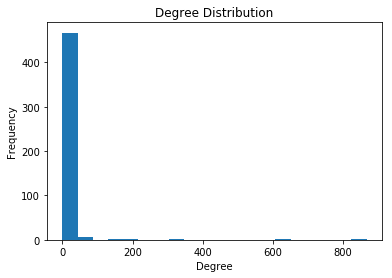

In [19]:
plt.hist(nx.degree_histogram(G), bins= 20)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

### Assortativity 

In [20]:
# checking assorativity measure
#  The network is disassortative.
real_assortativity = nx.degree_assortativity_coefficient(G_undirected)
print(real_assortativity)

-0.00644091555309


There happens to be a similarity measure called assortativity where nodes of a certain type tend to be connected to nodes of the same type. In networkx there is a function called degree assortativity which tells us how strongly nodes of similar degree are attached to each other. If the network has high degree assortativity, then low degree nodes will be connected to other low degree nodes, and high degree nodes will be connected to other high degree nodes. Conversely, low degree assortativity (or even disassortativity) would imply no (or negative) relationship.

In [21]:
air_degree_sequence = list(dict(nx.degree(G_undirected)).values())

model_assortativity = []
for i in range(1000):
    # Use the configuration model to create a null graph
    null_graph = nx.configuration_model(air_degree_sequence)
    
    # We need to remove self-loops and parallel edges because they don't make
    # sense in this social network
    null_graph = nx.Graph(null_graph) # removes parallel edges
    null_graph.remove_edges_from(null_graph.selfloop_edges()) # removes self-loops
    
    # Calculate the model's assortativity and add it to the list
    model_assortativity.append(nx.degree_assortativity_coefficient(null_graph))

In [22]:
# Prepend the real assortativity to the model list and have scipy calculate the zscores
import scipy.stats as stats
zscores = stats.zscore([real_assortativity] + model_assortativity)

# Just print out the first score which corresponds to the real network
print(zscores[0])

6.32133753542


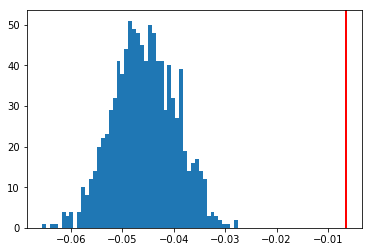

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

# Use the histogram function to plot the distribution of assortativity coefficients
plt.hist(model_assortativity, bins=50)

# axvline produces a vertical line at the designated x position on the graph
plt.axvline(real_assortativity, lw=2, color="red") #lw = 2 makes the line thicker
plt.show()

A z-score corresponds to how many standard deviations out from the mean the sample is. A score of +1 would be one standard deviation above the mean. Since the score is close to zero we can safely conclude that the disassortativity we observed in the air traffic network is explainable entirely from the degree sequence and no other special properties of the network.

### Robustness

In [24]:
def random_removal(graph, remove_frac):
    
    # copy of the graph that we can work on
    graph = graph.copy()
    
    # size of the largest graph component
    initial_largest = len(max(nx.connected_component_subgraphs(graph), key=len))
    
    # remove nodes
    graph.remove_nodes_from(np.random.choice(graph.nodes(), size=int(remove_frac), replace=False))

    if len(graph) > 0:
        relative_size_of_largest = len(max(nx.connected_component_subgraphs(graph), key=len)) / initial_largest
    else:
        relative_size_of_largest = 0.0
        
    return relative_size_of_largest

In [25]:
def targeted_removal(graph, remove_frac):
    # copy the graph
    graph = graph.copy()

    # again get the largest component of the graph
    initial_largest = len(max(nx.connected_component_subgraphs(graph), key=len))
    
    # sort nodes by top degree
    top_degree = sorted(graph.degree(), key=lambda x:x[1], reverse = True)
    #print(top_degree)
    # prep the list of nodes to remove from graph
    top_nodes=[item[0] for item in top_degree][0:remove_frac]
    # remove nodes
    graph.remove_nodes_from(top_nodes)

    #print(graph.number_of_nodes())
    #print(nx.connected_component_subgraphs(graph))
    
    if len(graph)> 0:
        
        relative_size_of_largest = len(max(nx.connected_component_subgraphs(graph), key=len))/ initial_largest
        
    else: 
        relative_size_of_largest = 0.0
        
    return relative_size_of_largest


In [26]:
# number of nodes to remove and at which intervals - 3000 nodes at intervals at 200 because the graph is large
nodes_to_remove = range(0, 3000, 200)
print(nodes_to_remove)

range(0, 3000, 200)


In [27]:
# get the largest component of the undirected graph
G_largest = max(nx.connected_component_subgraphs(G_undirected), key=len)

In [28]:
print(nx.info(G_largest))

Name: 
Type: Graph
Number of nodes: 3397
Number of edges: 19231
Average degree:  11.3223


In [29]:
# create a random graph for comparison purposes
random_graph = nx.erdos_renyi_graph(3397, 0.003)
print(nx.info(random_graph))

Name: 
Type: Graph
Number of nodes: 3397
Number of edges: 17315
Average degree:  10.1943


In [30]:
# random removal on the G_largest graph; based on the list "nodes to remove" that we created
random_on_real = np.array([random_removal(G_largest, frac) for frac in nodes_to_remove])

# random removal on the random graph
random_on_rand = np.array([random_removal(random_graph, frac) for frac in nodes_to_remove])

# targeted removal on G_largest graph
targeted_on_real = np.array([targeted_removal(G_largest, frac) for frac in nodes_to_remove])

# targeted removal on random graph
targeted_on_rand = np.array([targeted_removal(random_graph, frac) for frac in nodes_to_remove])

In [31]:
print(targeted_on_real)

[  1.00000000e+00   6.74124227e-01   1.08036503e-01   3.29702679e-02
   1.50132470e-02   5.88754784e-03   3.82690609e-03   3.53252870e-03
   2.35501913e-03   2.35501913e-03   1.47188696e-03   1.47188696e-03
   1.17750957e-03   2.94377392e-04   2.94377392e-04]


In [35]:
#compute the value for which the largest connected component drops below 1%
#random_on_real_critical_index = np.where(random_on_real < 0.1)
#random_on_rand_critical_index = np.where(random_on_rand < 0.1)
#targeted_on_real_graph_critical_index = np.where(targeted_on_real < 0.1)
#targeted_on_rand_graph_critical_index = np.where(targeted_on_rand < 0.1)

In [36]:
#print(random_on_real_critical_index)
#print(random_on_real)
#print(targeted_on_rand)

(array([14], dtype=int64),)


Text(0.5,0,'Removed Nodes')

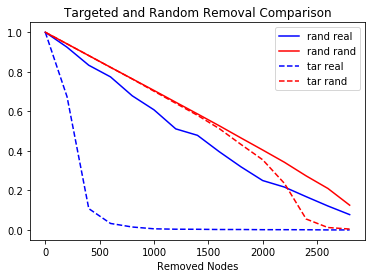

In [38]:
plt.plot(nodes_to_remove, random_on_real, color = 'blue', ls='-', label ='rand real')
plt.plot(nodes_to_remove, random_on_rand, color = 'red', ls='-', label ='rand rand')
plt.plot(nodes_to_remove, targeted_on_real, color = 'blue', ls='--', label ='tar real')
plt.plot(nodes_to_remove, targeted_on_rand, color = 'red', ls='--', label ='tar rand')
plt.legend(loc="upper right")
plt.title('Targeted and Random Removal Comparison')
plt.xlabel('Removed Nodes')

The real graph under random removal is fairly robust, a little less robust than the random graph. The targeted removal for our real graph shows that it is not very robust compared to the random graph. It looses most of its structure when we remove less than 500 nodes, while the random graph doesn't have that steep drop  after the first 500 nodes removed.